In [2]:
import os

path = 'data/DFMM-Spotlight/'

In [3]:
os.listdir(path + 'mask')[0]

'WOMEN-Pants-id_00001236-02_4_full_mask_0.png'

In [7]:
len(os.listdir(path + 'train_images'))

10335

In [8]:
len(os.listdir(path + 'test_images'))

1149

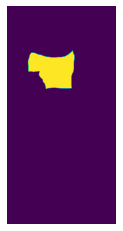

In [5]:
from PIL import Image
import matplotlib.pyplot as plt

image = Image.open(path + 'mask/' + os.listdir(path + 'mask')[0])
plt.imshow(image)
plt.axis('off')  # Hide axes
plt.show()

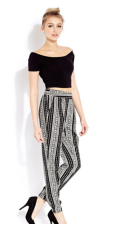

In [10]:
from PIL import Image
import matplotlib.pyplot as plt

image = Image.open('data/DFMM-Spotlight/train_images/WOMEN-Pants-id_00001236-02_4_full.png')
plt.imshow(image)
plt.axis('off')  # Hide axes
plt.show()

In [2]:
import os
import math
import random
import numpy as np
from pathlib import Path
from typing import Optional
from tqdm.auto import tqdm

import torch
import torch.nn.functional as F
import torch.utils.checkpoint
from torch.utils.data import DataLoader

from torchvision import transforms
from datasets import load_dataset

# from transformers import CLIPTextModel, CLIPTokenizer
# from transformers import get_constant_schedule_with_warmup

In [3]:
# training parameters
resolution = 512  # image resolution for training
train_batch_size = 4  # adjust based on your gpu memory
num_train_epochs = 10  # number of training epochs
max_train_steps = None  # if set, overrides num_train_epochs
gradient_accumulation_steps = 1  # for effective larger batch size
learning_rate = 1e-5  # training learning rate
lr_scheduler = "constant"  # learning rate scheduler type
lr_warmup_steps = 0  # warmup steps for learning rate
adam_beta1 = 0.9  # adam optimizer beta1
adam_beta2 = 0.999  # adam optimizer beta2
adam_weight_decay = 1e-2  # weight decay for regularization
adam_epsilon = 1e-08  # small epsilon for numerical stability
max_grad_norm = 1.0  # gradient clipping norm
checkpointing_steps = 500  # save checkpoint every n steps

In [4]:
import os
import json
from datasets import Dataset
from PIL import Image
from tqdm import tqdm

# Path setup
base_dir = "data/DFMM-Spotlight"
train_images_dir = os.path.join(base_dir, "train_images")
mask_dir = os.path.join(base_dir, "mask")
ann_file = os.path.join(base_dir, "mask_ann", "train_ann_file.jsonl")

# Load the annotation lines
with open(ann_file, "r") as f:
    lines = [json.loads(line.strip()) for line in f]

# Create data entries with full paths and loadable objects
data = []
for entry in tqdm(lines):
    image_path = os.path.join(train_images_dir, entry["image"])
    mask_path = os.path.join(mask_dir, entry["mask"])
    
    if os.path.exists(image_path) and os.path.exists(mask_path):
        data.append({
            "image_path": image_path,
            "mask_path": mask_path,
            "image": Image.open(image_path),
            "mask": Image.open(mask_path),
            "text": entry["text"]
        })
    else:
        print(f"Missing file for {entry['image']} or {entry['mask']}")

# Create HuggingFace dataset
train_dataset = Dataset.from_list(data)

100%|██████████| 21377/21377 [00:14<00:00, 1429.57it/s]


In [5]:
train_dataset

Dataset({
    features: ['image_path', 'mask_path', 'image', 'mask', 'text'],
    num_rows: 21377
})

In [6]:
image_column = "image"
caption_column = "text"

In [23]:
from torchvision import transforms

# # image transforms for training
# train_transforms = transforms.Compose([
#     transforms.Resize(
#         (resolution, resolution // 2), 
#         interpolation=transforms.InterpolationMode.BILINEAR
#     ),
#     transforms.CenterCrop(resolution),
#     transforms.RandomHorizontalFlip(),
#     transforms.ToTensor(),
#     transforms.Normalize([0.5], [0.5]),
# ])

# # mask transforms
# train_mask_transforms = transforms.Compose([
#     transforms.Resize(
#         (resolution, resolution // 2), 
#         interpolation=transforms.InterpolationMode.NEAREST
#     ),
#     transforms.CenterCrop(resolution),  # this ensures the same final shape as image
#     transforms.ToTensor(),
# ])

from torchvision.transforms import functional as TF
import random

def joint_transform(image, mask, resolution):
    # Resize image and mask
    image = TF.resize(image, size=(resolution, resolution // 2), interpolation=TF.InterpolationMode.BILINEAR)
    mask = TF.resize(mask, size=(resolution, resolution // 2), interpolation=TF.InterpolationMode.NEAREST)

    # Center crop both
    image = TF.center_crop(image, output_size=[resolution, resolution])
    mask = TF.center_crop(mask, output_size=[resolution, resolution])

    # Random horizontal flip
    if random.random() > 0.5:
        image = TF.hflip(image)
        mask = TF.hflip(mask)

    # To tensor
    image = TF.to_tensor(image)
    image = TF.normalize(image, [0.5], [0.5])
    mask = TF.to_tensor(mask)

    return image, mask


In [24]:
# preprocessing function
def preprocess_train(examples):
    images = [image.convert("RGB") for image in examples[image_column]]  # convert images to RGB format
    masks = [mask for mask in examples['mask']]  # extract masks (assumes dataset has a 'mask' column)
    
    examples["pixel_values"] = []
    examples["pixel_mask_values"] = []

    for img, mask in zip(images, masks):
        img_t, mask_t = joint_transform(img, mask, resolution)
        examples["pixel_values"].append(img_t)
        examples["pixel_mask_values"].append(mask_t)
    
    # create masked pixel values by applying mask to image
    examples["masked_pixel_values"] = [
        torch.masked_fill(
            examples["pixel_values"][i], 
            examples["pixel_mask_values"][i].bool(), 
            0
        ) for i in range(len(images))
    ]
    
    # tokenize the captions
    captions = []
    for caption in examples[caption_column]:
        if isinstance(caption, str):
            captions.append(caption)
        elif isinstance(caption, (list, np.ndarray)):
            captions.append(random.choice(caption))
        else:
            raise ValueError("Caption column should contain strings or lists of strings.")
            
    inputs = tokenizer(
        captions, 
        max_length=tokenizer.model_max_length, 
        padding="max_length", 
        truncation=True, 
        return_tensors="pt"
    )
    examples["input_ids"] = inputs.input_ids
    
    return examples

# apply preprocessing to the dataset
train_dataset = train_dataset.with_transform(preprocess_train)

In [25]:
# collate function for the dataloader
def collate_fn(examples):
    # stack the tensors
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    pixel_values = pixel_values.to(memory_format=torch.contiguous_format).float()    
    pixel_mask_values = torch.stack([example["pixel_mask_values"] for example in examples])
    pixel_mask_values = pixel_mask_values.to(memory_format=torch.contiguous_format)
    masked_pixel_values = torch.stack([example["masked_pixel_values"] for example in examples])
    masked_pixel_values = masked_pixel_values.to(memory_format=torch.contiguous_format).float()
    
    # stack the tokenized text
    input_ids = torch.stack([example["input_ids"] for example in examples])
    
    return {
        "pixel_values": pixel_values, 
        "pixel_mask_values": pixel_mask_values,
        "masked_pixel_values": masked_pixel_values, 
        "input_ids": input_ids
    }

# create DataLoader for training
train_dataloader = DataLoader(
    train_dataset,
    shuffle=True,
    collate_fn=collate_fn,
    batch_size=train_batch_size,
    num_workers=2,  # adjust based on your CPU (can be found out using os.cpu_count())
)

In [1]:
from transformers import CLIPTextModel, CLIPTokenizer
from transformers import get_constant_schedule_with_warmup

In [26]:
pretrained_model_name_or_path = "runwayml/stable-diffusion-v1-5"  

# tokenizer for processing text prompts
tokenizer = CLIPTokenizer.from_pretrained(
    pretrained_model_name_or_path, 
    subfolder="tokenizer"
)

/home/eqp6pg/.conda/envs/my-torch/lib/python3.8/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


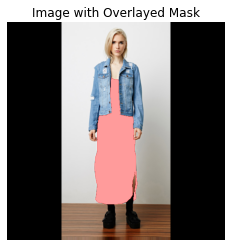

Caption Token IDs: tensor([49406,  1538,   268, 10536,  7050,  1449,  2595, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407])


In [33]:
import torchvision.transforms.functional as F
import matplotlib.pyplot as plt
from PIL import Image

# Get a batch
batch = next(iter(train_dataloader))

# Select the first image and mask from batch
img_tensor = batch['pixel_values'][0]
mask_tensor = batch['pixel_mask_values'][0]

# Unnormalize image tensor and convert to PIL
img_pil = F.to_pil_image((img_tensor * 0.5 + 0.5).clamp(0, 1))

# Convert mask to a binary mask image (0 or 255)
mask_pil = F.to_pil_image(mask_tensor).convert("L")  # "L" mode for grayscale

# Optionally: apply a color to the mask
mask_colored = Image.new("RGBA", mask_pil.size, color=(255, 0, 0, 100))  # Red with alpha
mask_binary = mask_pil.point(lambda x: 255 if x > 0 else 0).convert("1")  # binary mask

# Paste the red mask over the image using binary mask as alpha mask
img_overlay = img_pil.convert("RGBA").copy()
img_overlay.paste(mask_colored, mask=mask_binary)

# Display overlay
plt.imshow(img_overlay)
plt.title("Image with Overlayed Mask")
plt.axis('off')
plt.show()

# Optional: print caption token IDs
print("Caption Token IDs:", batch['input_ids'][0])